# Modelo de equação diferencial ordinária


Matheus Elis da Silva  
matheuselis@id.uff.br


## Modelos Compartimentais

Muitos modelos epidemiológicos são compartimentais, o que significa que a população é dividida em várias subpopulações discretas, com fluxos entre as subpopulações modelados por meio de equações diferenciais ordinárias (EDOs). Na maioria dos casos, esses modelos são não lineares e são necessárias técnicas numéricas para resolver a dinâmica ao longo do tempo. ou um determinado conjunto de valores de parâmetro, o modelo irá gerar a mesma saída, portanto, esses modelos são conhecidos como determinísticos. Esses modelos geram saída, por exemplo o número de indivíduos infectados ao longo do tempo que são contínuos no tempo e em número, ou seja, é possível ter 1,1 indivíduos infectados e assim por diante. Podemos pensar nisso como uma aproximação da média de muitas epidemias estocásticas ao longo do tempo, mais sobre isso nas seções subsequentes.

Algoritmos para resolver ODEs são implementados em muitas linguagens de computador, tornando relativamente simples simular esses modelos.

### Descrição

O modelo susceptivel-infeccioso-recuperado (SIR) em uma população fechadas foi proposto por Kermack e McKendrick como um caso especial de um modelo mais geral, e a forma estruturada de muito mais modelos compartimentados. Indivíduos susceptiveis, $S$, são infectados por indivíduos infecciosos, $I$, a uma taxa per-capita $\beta I$, e indivíduos infecciosos são recuperadas a uma taxa per-capita $\gamma$ para se tornarem indivíduos recuperados, $R$.

### Equações 

$$
\begin{align*} 
\frac{dS(t)}{dt} = -\beta S(t) I(t)/N\\
\frac{dI(t)}{dt} = \beta S(t) I(t)/N - \gamma I(t)\\
\frac{dR(t)}{dt} = \gamma I(t)\\
\end{align*}
$$

### Condições Iniciais

* O modelo de esquações ondinárias considera
    - Susceptivel, $S$, com condição inicial $S(0) = 990$
    - Infeccioso, $I$, com condição inicial $I(0) = 10$
    - Recuperado, $R$, com condição inicial $R(0) = 0$
    - População total, $N=S+I+R=1000$
* Indivíduos susceptiveis fazendo contato com outros indivíduos a uma taxa $c(=10)$, com a probabilidade de um contato com uma pessoa infecciosa ser $I/N$. Com probabilidade $\beta = 0.05$, uma pessoa infectada infectará um suscetível dado um contato.
* Os indivíduos infectados se recuperam a uma taxa per capita $\gamma = 0.25$.


A versão classica do SIR em ODE é dada por:
   * Determinística
   * Continuo no tempo
   * Contínuo no estado

## Implementação em Julia

### Bibliotecas

Inicialmente precisamos instalar e carregar as bibliotecas no ambiente de programação.  
Só é necessario instalar as bibliotecas uma unica vez no computador, após isso as funções `Pkg.add()` podem ser comentadas

In [1]:
using Pkg
#Pkg.add("DifferentialEquations")
#Pkg.add("SimpleDiffEq")
#Pkg.add("DataFrames")
#Pkg.add("StatsPlots")
#Pkg.add("BenchmarkTools")


In [2]:
using DifferentialEquations
using SimpleDiffEq
using DataFrames
using StatsPlots
using BenchmarkTools

### ODE

A função a seguir define as equações diferenciais do modelo que serão utilizadas para a simulação. As variaveis de estados e os parametros foram alocados em `u` e `p`, isso causa uma pequena diminuição de perfomace entretanto a equação fica mais facil de ser lida

In [3]:
function sir_ode!(du,u,p,t)
    (S,I,R) = u
    (β,c,γ) = p
    N = S+I+R
    @inbounds begin
        du[1] = -β*c*I/N*S
        du[2] = β*c*I/N*S - γ*I
        du[3] = γ*I
    end
    nothing
end;

### Domínio do Tempo

Nós agora precisamos setar um intervalo de tempo em que a simulação irá funcionar e que será dado por `tspan`, o salto de tempo que será dado por `δt` e o tempo maximo que será dado por `tmax`.

In [4]:
δt = 0.1
tmax = 40.0
tspan = (0.0,tmax)
t=0.0:δt:tmax;

### Condições iniciais 

Agora iremos setar as condições iniciais de $S_0$, $I_0$ e $R_0$ para a simulação.

In [5]:
u0 = [990.0,10.0,0.0]; # S,I.R

### Parammetros do Modelo

Agora iremos definir os parametros $\beta$, $c$ e $\gamma$ das equações diferênciais.

In [6]:
p = [0.05,10,0.25]; # β,c,γ

### Execução do Modelo

Primeiro iremos gerar um objeto do tipo `ODEProblem` utilizando a função que modela a equação diferencial, `sir_ode`, as condições iniciais, `u0`, o intervalo de tempo, `tspan` e os paramêtros , `p`.

In [7]:
prob_ode = ODEProblem(sir_ode!,u0,tspan,p);

Logo após iremos utilizar a função `solve()` para resolver o objeto criado acima.


In [8]:
sol_ode = solve(prob_ode,saveat = δt);

### Pós processamento

Para ficar mais facil de vizulizar os dados iremos juntar o output da função `solve()` em um dataframe.

In [9]:
df_ode = DataFrame(sol_ode)
df_ode[!,:t] = t

0.0:0.1:40.0

### Plot do Resultado

Agora nós podemos plotar o resultado para vizualizar o resultado.

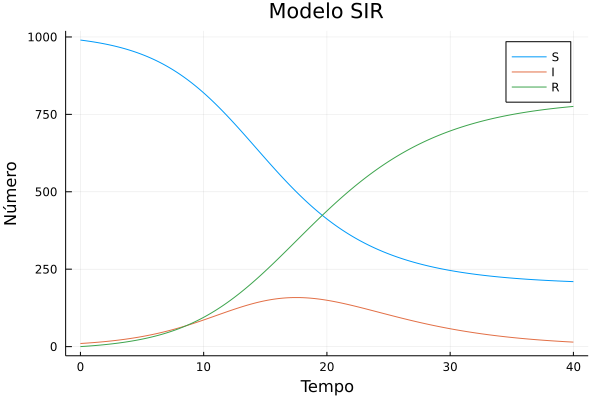

In [10]:
@df df_ode plot(:t,
    [:value1 :value2 :value3],
    label=["S" "I" "R"],
    xlabel="Tempo",
    ylabel="Número",
    title = "Modelo SIR")

In [11]:
savefig("SIR.png")

## Benchmarking do problema

Para fazer um benchmarking de uma função basta utilizar a função `@benchmark` antes da função desejada

In [12]:
@benchmark solve(prob_ode)

BenchmarkTools.Trial: 
  memory estimate:  31.81 KiB
  allocs estimate:  294
  --------------
  minimum time:     26.700 μs (0.00% GC)
  median time:      36.300 μs (0.00% GC)
  mean time:        47.656 μs (7.94% GC)
  maximum time:     16.038 ms (99.53% GC)
  --------------
  samples:          10000
  evals/sample:     1

## Multiplos problemas

In [13]:
p1 = [0.05,10,0.25] # β,c,γ
p2 = [0.05,15,0.25] # β,c,γ
p3 = [0.05,35,0.25]; # β,c,γ

In [14]:
prob_ode1 = ODEProblem(sir_ode!,u0,tspan,p1);
prob_ode2 = ODEProblem(sir_ode!,u0,tspan,p2);
prob_ode3 = ODEProblem(sir_ode!,u0,tspan,p3);

In [15]:
sol_ode1 = solve(prob_ode1,saveat = δt);
sol_ode2 = solve(prob_ode2,saveat = δt);
sol_ode3 = solve(prob_ode3,saveat = δt);

In [16]:
df_ode1 = DataFrame(sol_ode1)
df_ode2 = DataFrame(sol_ode2)
df_ode3 = DataFrame(sol_ode3);

In [17]:
plot(df_ode1.timestamp,
    [df_ode1.value1 df_ode2.value1 df_ode3.value1],
    label=["c = 10" "c = 15" "c = 35"],
    xlabel="Tempo",
    ylabel="Número",
    title = "Susceptiveis SIR")
savefig("s.png")

In [18]:
plot(df_ode1.timestamp,
    [df_ode1.value2 df_ode2.value2 df_ode3.value2],
    label=["c = 10" "c = 15" "c = 35"],
    xlabel="Tempo",
    ylabel="Número",
    title = "Infecciosos SIR")
savefig("i.png")

In [19]:
plot(df_ode1.timestamp,
    [df_ode1.value3 df_ode2.value3 df_ode3.value3],
    label=["c = 10" "c = 15" "c = 35"],
    xlabel="Tempo",
    ylabel="Número",
    title = "Recuperados SIR")
savefig("r.png")

In [20]:
last(df_ode1,6)

,timestamp,value1,value2,value3
,Float64,Float64,Float64,Float64
1,39.5,210.632,15.561,773.807
2,39.6,210.469,15.3374,774.193
3,39.7,210.309,15.1169,774.574
4,39.8,210.151,14.8995,774.949
5,39.9,209.996,14.6851,775.319
6,40.0,209.843,14.4736,775.684


In [21]:
γ = 0.25
β = 0.05
c = 5
R_0 = (β*c)/γ

1.0